# 1、导入模块

In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost.sklearn import XGBRegressor

warnings.filterwarnings('ignore')

# 2、导入数据

In [3]:
# 导入数据
train = pd.read_csv('happiness_train_complete.csv')
test = pd.read_csv('happiness_test_complete.csv')

# 3、数据预处理

In [4]:
train.describe()

,id,happiness,survey_type,province,city,county,gender,birth,nationality,religion,...,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
count,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.00000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000
mean,4000.50000,3.850125,1.405500,15.155375,42.564750,70.619000,1.53000,1964.707625,1.37350,0.772250,...,3.722250,70.809500,68.170000,62.737625,66.320125,62.794187,67.064000,66.09625,65.626750,67.153750
std,2309.54541,0.938228,0.491019,8.917100,27.187404,38.747503,0.49913,16.842865,1.52882,1.071459,...,1.143358,21.184742,20.549943,24.771319,22.049437,23.463162,21.586817,23.08568,23.827493,22.502203
min,1.00000,-8.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1921.000000,-8.00000,-8.000000,...,-8.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.00000,-3.000000,-3.000000
25%,2000.75000,4.000000,1.000000,7.000000,18.000000,37.000000,1.00000,1952.000000,1.00000,1.000000,...,3.000000,60.000000,60.000000,50.000000,60.000000,55.000000,60.000000,60.00000,60.000000,60.000000
50%,4000.50000,4.000000,1.000000,15.000000,42.000000,73.000000,2.00000,1965.000000,1.00000,1.000000,...,4.000000,79.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.00000,70.000000,70.000000
75%,6000.25000,4.000000,2.000000,22.000000,65.000000,104.000000,2.00000,1977.000000,1.00000,1.000000,...,5.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.00000,80.000000,80.000000
max,8000.00000,5.000000,2.000000,31.000000,89.000000,134.000000,2.00000,1997.000000,8.00000,1.000000,...,5.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000


观察后发现许多特征中存在负值，为异常值，应处理(-1 = 不适用; -2 = 不知道; -3 = 拒绝回答; -8 = 无法回答;)

In [7]:
def preprocessing(train, test):
    train = train.loc[train['happiness'] != -8]
    happiness = train["happiness"]

    # 将train和test连在一起
    data = pd.concat([train, test], axis=0, ignore_index=True)
    # 将异常值替换为NaN
    data.replace([-1, -2, -3, -8], np.nan, inplace=True)
    # 处理时间特征
    data['survey_time'] = pd.to_datetime(data['survey_time'], format='%Y/%m/%d %H:%M')
    data["weekday"] = data["survey_time"].dt.weekday
    data["year"] = data["survey_time"].dt.year
    data["quarter"] = data["survey_time"].dt.quarter
    data["hour"] = data["survey_time"].dt.hour
    data["month"] = data["survey_time"].dt.month
    # 做问卷时候的年龄
    data["survey_age"] = data["year"] - data["birth"]
    # 去掉"happiness"、"survey_time"、"id"
    data = data.drop(["happiness"], axis=1)
    data = data.drop(["survey_time"], axis=1)
    data = data.drop(["id"], axis=1)
    # 填充数据——非数据值
    data["edu_other"] = data["edu_other"].map(lambda x: 0 if pd.isnull(x) else 1)
    data["property_other"] = data["property_other"].map(lambda x: 0 if pd.isnull(x) else 1)
    data["invest_other"] = data["invest_other"].map(lambda x: 0 if pd.isnull(x) else 1)
    # 是否入党
    data["join_party"] = data["join_party"].map(lambda x: 0 if pd.isnull(x) else 1)
    # 填充数据——缺失值
    # 通过观察特征可以发现大多数类别特征的类别数在5个以内，以5为阈值初步区分数字特征与类别特征
    data_cat = data.loc[:, list(data.max() <= 5)]
    data_num = data.loc[:, list(data.max() > 5)]

    imputer_cat = SimpleImputer(strategy="most_frequent")
    imputer_num = SimpleImputer(strategy="median")
    imputer_cat.fit(data_cat)
    imputer_cat_trans = imputer_cat.transform(data_cat)
    imputer_num.fit(data_num)
    imputer_num_trans = imputer_num.transform(data_num)
    data[data_cat.columns] = imputer_cat_trans
    data[data_num.columns] = imputer_num_trans
    # 出生的年代
    data["birth_s"] = data["birth"].map(lambda x: int((x - 1920) / 10))
    # 将类别特征中特征值与特征含义没有明显线性关系的特征取出并进行one-hot编码处理
    cat_features = data.loc[:,
                   ['survey_type', 'province', 'city', 'county', 'gender', 'nationality', 'edu_status', 'political',
                    'hukou', 'hukou_loc', 'work_exper', 'work_status', 'work_type', 'work_manage', 'insur_1', 'insur_2',
                    'insur_3', 'insur_4', 'car', 'marital', 's_hukou', 's_work_status', 's_work_type', 'f_political',
                    'f_work_14', 'm_political', 'm_work_14']]
    encoder = OneHotEncoder()
    cat_features_1hot = encoder.fit_transform(cat_features.values)
    cat_features_1hot = cat_features_1hot.toarray()
    cat_features_1hot = pd.DataFrame(cat_features_1hot)
    # 将one-hot特征与原始特征合并
    data = pd.concat([data, cat_features_1hot], axis=1)
    # 删除经one-hot编码处理过的特征
    data.drop(['survey_type', 'province', 'city', 'county', 'gender', 'nationality', 'edu_status', 'political', 'hukou',
               'hukou_loc', 'work_exper', 'work_status', 'work_type', 'work_manage', 'insur_1', 'insur_2', 'insur_3',
               'insur_4', 'car', 'marital', 's_hukou', 's_work_status', 's_work_type', 'f_political', 'f_work_14',
               'm_political', 'm_work_14'], axis=1, inplace=True)

    X_train_data = data[:train.shape[0]]
    X_test_data = data[train.shape[0]:]

    X_train = np.array(X_train_data)
    y_train = np.array(happiness)
    X_test = np.array(X_test_data)

    return X_train, y_train, X_test

# 5、模型训练和评估

In [9]:
X_train, y_train, X_test = preprocessing(train, test)
X_train

array([[1.959e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.992e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.967e+03, 0.000e+00, 3.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [1.967e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.978e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.991e+03, 1.000e+00, 1.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00]])

In [15]:
X_train_train, X_train_test, \
    y_train_train, y_train_test = train_test_split(X_train, y_train,
                                                   test_size=0.2, random_state=2011141121)

In [30]:
X_train_train, y_train_train

(array([[1.956e+03, 0.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.969e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.976e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [1.957e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.929e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.987e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00]]),
 array([5, 4, 3, ..., 5, 4, 4]))

In [31]:
X_train_test, y_train_test

(array([[1.941e+03, 0.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.946e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.946e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [1.935e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.968e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.964e+03, 1.000e+00, 3.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00]]),
 array([4, 4, 4, ..., 4, 4, 2]))

In [33]:
model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.1,
                     colsample_bytree=0.971, gamma=0.11, learning_rate=0.069,
                     max_delta_step=0, max_depth=3, min_child_weight=1,
                     n_estimators=499, n_jobs=-1, nthread=50,
                     objective='reg:squarederror', random_state=0, reg_alpha=0.1,
                     reg_lambda=1, scale_pos_weight=1, seed=None, subsample=1.0, eval_metric=mean_squared_error)
model.fit(X_train_train, y_train_train,
          eval_set=[(X_train_test, y_train_test)], verbose=False)
loss = model.evals_result()
loss = loss['validation_0']['mean_squared_error']
len(loss), loss

(499,
 [10.525129,
  9.203202,
  8.060719,
  7.061203,
  6.201997,
  5.452072,
  4.80102,
  4.240627,
  3.751566,
  3.327907,
  2.955433,
  2.63442,
  2.353517,
  2.110657,
  1.902305,
  1.718907,
  1.561577,
  1.422136,
  1.303808,
  1.199896,
  1.110435,
  1.03147,
  0.961334,
  0.900099,
  0.847758,
  0.803476,
  0.762508,
  0.726674,
  0.696604,
  0.670793,
  0.647323,
  0.628601,
  0.611573,
  0.596727,
  0.583311,
  0.571853,
  0.560975,
  0.552617,
  0.54406,
  0.537064,
  0.530435,
  0.525127,
  0.519691,
  0.515524,
  0.511851,
  0.507514,
  0.504144,
  0.50108,
  0.498932,
  0.496738,
  0.494724,
  0.493158,
  0.491328,
  0.489647,
  0.488382,
  0.48719,
  0.486055,
  0.484454,
  0.48374,
  0.482874,
  0.482563,
  0.481886,
  0.480995,
  0.480116,
  0.479595,
  0.478788,
  0.478532,
  0.477889,
  0.477351,
  0.476812,
  0.476601,
  0.476022,
  0.474969,
  0.474988,
  0.47458,
  0.474259,
  0.473664,
  0.472909,
  0.47297,
  0.472925,
  0.47253,
  0.47228,
  0.472027,
  0.4718

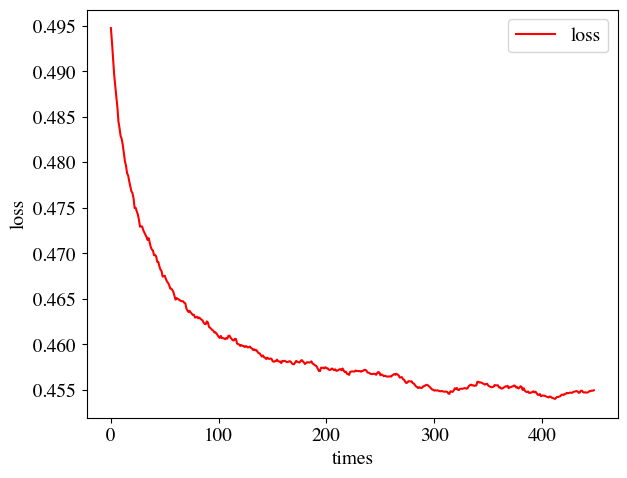

In [26]:
from matplotlib.font_manager import FontProperties

# 设置新罗马字体
font = FontProperties(fname='/System/Library/Fonts/Times.ttc', size=14)
plt.rcParams['font.family'] = font.get_name()
plt.rcParams['font.size'] = font.get_size()

plt.figure()
plt.subplots_adjust(left=0.14, top=0.96, right=0.97)
plt.plot(range(len(loss[50:])), loss[50:], 'r', label="loss")
plt.legend(loc="upper right")  # 显示图中的标签
plt.xlabel("times")
plt.ylabel('loss')
plt.savefig('loss-curve.svg', format='svg')
plt.show()

In [27]:
X_predict = pd.Series(model.predict(X_test)).astype(int)
predict_result = pd.DataFrame(X_predict, columns=['predict'])
predict_result.to_csv('predict.csv', index=False)
predict_result

,predict
0,3
1,3
2,3
3,4
4,3
...,...
2963,4
2964,3
2965,4
2966,4
